<a href="https://colab.research.google.com/github/rmaffulli/MI_tutorial/blob/main/MI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Information Theory in neuroscience
Aims of the tutorial:
- Understand the concept of entropy, conditional entropy, and mutual information
- Discuss the reasons for binning a continuous signal, the implications introduce some binning strategies and discuss their pros/cons
- Introsuce the problem of limited-sampling bias: origin, implications and mitigation strategies
- Discuss the effect of correlated firing in a neuronal population on information

Suggested reading for a deeper understanding of the topics covered in this tutorial:
1. Timme, Nicholas M., and Christopher Lapish. "A tutorial for information theory in neuroscience." eneuro 5.3 (2018).
1. Quiroga, R. Q., & Panzeri, S. (2009). Extracting information from neuronal populations: information theory and decoding approaches. Nature Reviews Neuroscience, 10(3), 173-185.
1. Averbeck, B., Latham, P. & Pouget, A. Neural correlations, population coding and computation. Nat Rev Neurosci 7, 358–366 (2006). https://doi.org/10.1038/nrn1888 and references.

---
# Setup

In [ ]:
#@title Import
!pip install pydataset
import pydataset
from pydataset import data
import numpy as np
import random as rnd
from matplotlib import pyplot as plt
from scipy.stats import poisson
import warnings

rnd.seed(2020)
warnings.filterwarnings('ignore')

     |████████████████████████████████| 15.9MB 300kB/s 
  Created wheel for pydataset: filename=pydataset-0.2.0-cp36-none-any.whl size=15939432 sha256=0e6618f808e4fc1f746c5e73b0544c60deaf236fad8e3da25e13face766ee34d
  Stored in directory: /root/.cache/pip/wheels/fe/3f/dc/5d02ccc767317191b12d042dd920fcf3432fab74bc7978598b
Successfully built pydataset
initiated datasets repo at: /root/.pydataset/


In [ ]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/rmaffulli/MI_tutorial/main/figures.mplstyle")

In [ ]:
#@title Helper functions
def bin_data(data,nbins,mode):
  if mode == 'eqspace':
    bins = np.linspace(np.min(data)-0.1,np.max(data)+0.1,nbins+1)
    data_binned = np.digitize(data,bins,right=True)
  return data_binned

---
# Generation of Poisson spikes
We know that spikes are binary discrete events.
It is often assumed, in first approximation, that each spike is independent of the previous/following one. This implies that the probability of having a spike at a certain time is not influenced by the probability that a spike has occurred previously. This *model* (beware! this is a model the behaviour of a neuron) is consistent with a spike event to be drawn from a Poisson distribution.

*Food for toughts: what are the mechanisms that invalidate the Poisson assumption? Can we think of some reasons to doubt that a spiking neuron is Poissonian?*

In the cell below you can explore the function generating poissonian spike trains.

In [ ]:
#@title Spike generation function
def poisson_spike(t,rate):
  # t: time points
  # rate: spiking rate in Hz
  dt = t[1] - t[0];
  sp = np.zeros_like(t)
  for i,tp in enumerate(t):
    if rnd.uniform(0,1) <= dt*rate:
      sp[i] = 1
  
  return sp

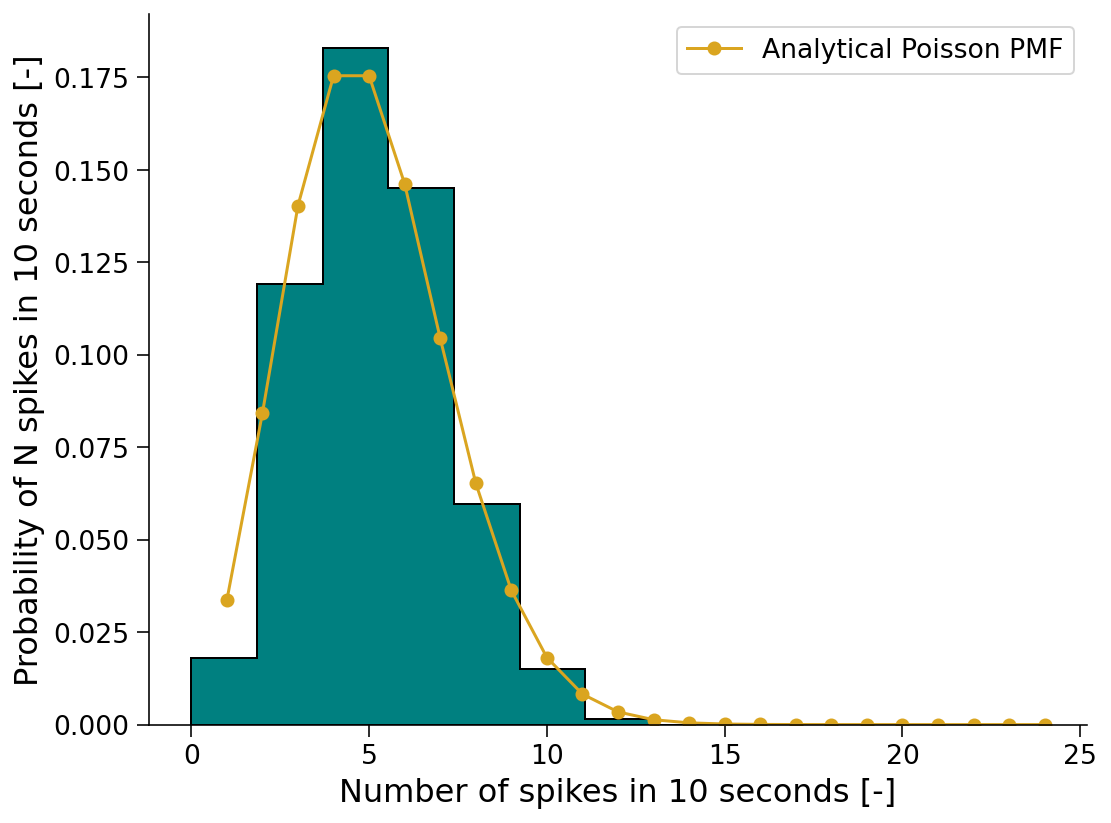

In [ ]:
#@title The effect of the number of trials on estimation of probabiltiy mass function { run: "auto" }
trials = 1 #@param {type:"slider", min:1, max:1000, step:1}
rate = 0.5 #@param {type:"slider", min:0.1, max:10, step:0.1}

spike_cnt = np.zeros((trials,))

t = np.linspace(0,10,1000)
for tr in range(trials):
  sp = poisson_spike(t,rate)
  spike_cnt[tr-1] = sum(sp)

_ = plt.hist(spike_cnt,
             range=(0, 2*int(spike_cnt.max())),
             bins=int(spike_cnt.max() + 1),
             density=True, histtype='stepfilled',
             color='teal', edgecolor='black')
x_poisson = np.linspace(1,2*int(spike_cnt.max()),2*int(spike_cnt.max()))
_ = plt.plot(x_poisson, poisson.pmf(x_poisson, rate*10),
             '-o', label='Analytical Poisson PMF',
            color='goldenrod')
plt.xlabel('Number of spikes in 10 seconds [-]')
plt.ylabel('Probability of N spikes in 10 seconds [-]')
_ = plt.legend()

---
# Entropy of a random variable
In this section we will:
- Learn how to calculate the entropy of a random variable
- Understand how the probability distribution of such random variable influences its entropy

Given a Random Variable (RV) $R$, its entropy is defined as:

$H(R) = \sum\limits_{r\in X}p(x)log_2\frac{1}{p(x)}$

in the section below we will implement the following functions:

- `def marginal_p(x):` to calculate the marginal probability of a RV $X$
- `def entropy(x):` to calculate the entropy of $(X)$

In [ ]:
def marginal_p(x):
  # returns marginal probabiltiy of random variable X based on observations x
  # x is a column vector: rows are the trials
  # find unique values of x and count the number of occurrences across trials
  x_values, p_x = np.unique(x, axis=0, return_counts=True)
  # calculate probabilities of each occurrences
  p_x = p_x/np.shape(x)[0]
  # return probability vector
  return p_x


def entropy(x):
  # returns entropy of random variable X
  # x is a column vector: rows are the trials
  # initialize entropy
  ent = 0
  # calculate marginal probability
  p_x = marginal_p(x)
  # calculate entropy
  for p in p_x:
    ent += p*np.log2(1/p)
  # return entropy
  return ent

x = np.asarray([1, 1, 0, 0])
print(entropy(x))
if entropy(x) == 1:
  print("Correct! the value of entropy(x) is: " + str(entropy(x)))
else:
  raise NotImplementedError("Wrong values of entropy, double check the implementation of entropy and marginal functions")

1.0
Correct! the value of entropy(x) is: 1.0


Entropy: 1.0931834865071652 [bits]


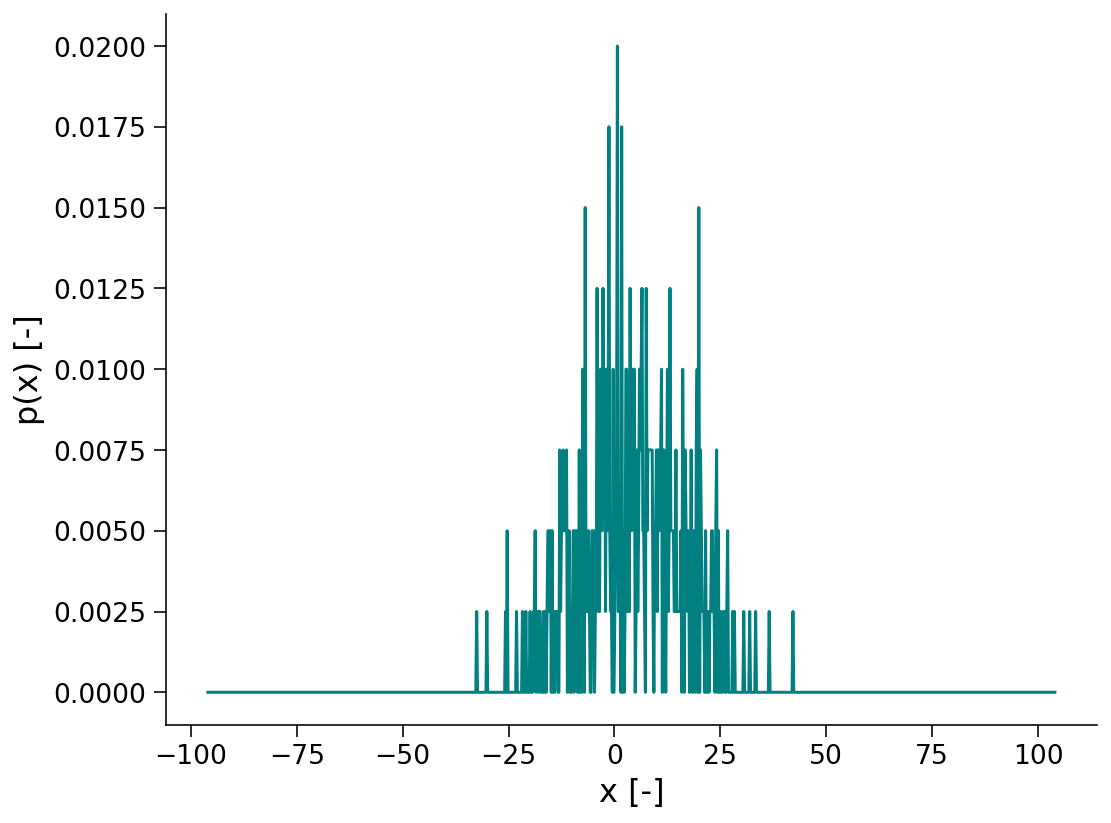

In [ ]:
#@title Entropy of a Gaussian random variable { run: "auto" }
mean = 4 #@param {type:"slider", min:-5, max:5, step:1}
std = 12 #@param {type:"slider", min:0.5, max:20, step:0.5}
trials = 400 #@param {type:"slider", min:100, max:100000, step:100}

x = np.random.normal(mean,std,trials)
bins = np.linspace(mean-100,mean+100,1000)
x_binned = np.zeros_like(bins)
for i in np.digitize(x,bins,right=True):
  x_binned[i-1] += 1
p_x = x_binned/sum(x_binned)
_ = plt.plot(bins,p_x,color='teal')
plt.xlabel('x [-]')
plt.ylabel('p(x) [-]')

print("Entropy: " + str(entropy(x_binned)) + " [bits]")

## Discussion
- What is the effect of the standard deviation on entropy? Why? What pdf do you expect to carry maximum entropy?
- What is the effect of the mean?
- What is the effect of the number of trials?

---
# Conditional entropy of two random variables
In this section we will:
- Learn how to calculate the conditional entropy of one random variable X given a second variable Y

In the section below we will implement the following functions:

- `def joint_p(x,y):` to calculate the joint probability of $(X;Y)$
- `def conditional_p(x,y):` to calculate the conditional probability of a $(X|Y)$
- `def conditional_entropy(x,y):` to calculate the conditional entropy of $(X|Y)$

In [ ]:
def joint_p(x,y):
  # returns joint probabiltiy of random variables (X;Y) based on observations x,y
  # x is a column vector: rows are the trials
  # y is a column vector: rows are the trials
  # the output value p_xy should be a matrix with rows number equal to the unique values of x and columns number equal to the unique values of y
  # find unique values of x and count the number of occurrences across trials
  x_values, p_x = np.unique(x, axis=0, return_counts=True)
  y_values, p_y = np.unique(y, axis=0, return_counts=True)
  # initialize joint probability matrix
  p_xy = np.zeros((x_values.size, y_values.size))
  # calculate probabilities of each occurrences
  for x_r,y_r in zip(x,y):
    i = np.where(x_values == x_r)
    j = np.where(y_values == y_r)
    p_xy[i,j] += 1

  p_xy = p_xy/np.shape(x)[0]
  # return probability matrix
  return p_xy


def conditional_p(x,y):
  # returns conditional probabiltiy (X|Y) based on observations x,y
  # x is a column vector: rows are the trials
  # x is a column vector: rows are the trials
  # HINT: use Bayes' formula!!!
  p_xy = joint_p(x,y)
  p_y = marginal_p(y)
  p_x_cond_y = np.zeros_like(p_xy)
  # return conditional probability matrix
  p_x_cond_y = p_xy/p_y[None,:]
  return p_x_cond_y


def conditional_entropy(x,y):
  # returns conditional entropy (X|Y) based on observations x,y
  # x is a column vector: rows are the trials
  # y is a column vector: rows are the trials
  # initialize entropy
  # calculate joint probability
  p_xy = joint_p(x,y)
  # calculate conditional probability
  p_x_cond_y = conditional_p(x,y)
  # calculate entropy
  cond_entr = np.nansum(np.multiply(p_xy,np.log2(1/p_x_cond_y)))
  # return entropy
  return cond_entr

x = np.asarray([1, 2, 3, 4])
y = np.asarray([1, 1, 2, 2])
if conditional_entropy(x,y) == 1:
  print("Correct! the value of entropy(x) is: " + str(conditional_entropy(x,y)))
else:
  raise NotImplementedError("Wrong values of entropy, double check the implementation of entropy and marginal functions")

Correct! the value of entropy(x) is: 1.0


## Calculate the conditional entropy of real world data
We will now play a bit with real data. We will import a dataset of property prices in the suburbs of Boston and investigate the conditional entropy between a few variables in this dataset.

Source: The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air' J. Environ. Economics & Management, vol.5, 81-102, 1978.

In [ ]:
#@title {run: "auto" }
x_var = "nox" #@param ["crim", "nox", "ptratio", "age", "medv"]
y_var = "crim" #@param ["crim", "nox", "ptratio", "age", "medv"]
axis_labels = {
    "crim":"Per capita crime rate by town",
    "nox":"Nitric oxides concentration (parts per 10 million)",
    "ptratio":"Pupil-teacher ratio by town",
    "age":"Proportion of owner-occupied units built prior to 1940",
    "medv":"Median value of owner-occupied homes in $1000's"
}
# Import data
imported_data = data('Boston')
x = imported_data[x_var]
y = imported_data[y_var]

# bin data
x_binned = bin_data(x,10,'eqspace')
y_binned = bin_data(y,10,'eqspace')

plt.scatter(x,y,color='teal')
plt.xlabel(axis_labels[x_var])
plt.ylabel(axis_labels[y_var])

print("Entropy x = ", entropy(x_binned))
print("Entropy y = ", entropy(y_binned))
print("Conditional entropy (x|y)) =  "
 + str(conditional_entropy(x_binned,y_binned)))

## A note
- Never forget that marginal, joint and conditional probability bare related through Bayes rule: $$ p(X|Y) = \frac{p(X,Y)}{p(Y)} $$
so you normally have just to calculate two of them and use Bayes rule to obtain the third one!

## Discussion
- Can you see a relation between the distributions of X, Y and the conditional entropy $H(X|Y)$?
  - Try to see what happens with `'crim'` as $X$ and `'nox'` as $Y$
  - What happens with the inverse (i.e. `'crim'` as $Y$ and `'nox'` as $X$)? Is conditional entropy invariant to swapping $X$ and $Y$?
  - What is the conditional entropy of a variable with itself?
  - What is the conditional entropy of `'age'` as $X$ and `'medv'` as $Y$?
  - Do you think that conditional entropy alone is enough to characterize the dependence between two variables? How do you define *high* vs *low* values of conditional entropy?

---
# Mutual Information
Conditional entropy is an indication of how much entropy is left in a variable once we have observed another one. It is as such an indicator of the dependence between two variables but cannot tell us how informative is a variable about another one as it does not give us a comparison term to define how *high* or *low* this the information content that one variable has with respect to the other one. This is precisely the role of mutual information.

Mutual information is defined as:
$$MI(X;Y) = H(X) - H(X|Y)$$
and it quantifies how much uncertainty is left in $X$ once we have observed variable $Y$. In this way it relates the conditional entropy $H(X|Y)$ with the total entropy $H(X)$. 

In this section we will:
- Learn how to calculate mutual information between two random variables
- Calculate MI for the Boston dataset analyzed above
- Introduce MI for a spike-rate coding Poisson spiking neuron

In the section below we will implement the following functions:

- `def mi(x,y):` to calculate the mutual information of $(X;Y)$

In [ ]:
def mi(x,y):
  # returns mutual information between (X;Y) based on observations x,y
  # x is a column vector: rows are the trials
  # y is a column vector: rows are the trials
  return entropy(x) - conditional_entropy(x,y)

Entropy x =  0.7738064057278412
Entropy y =  2.657795536964226
Conditional entropy (x|y)) =  0.4875340413216721
Mutual information (x;y)) =  0.2862723644061691


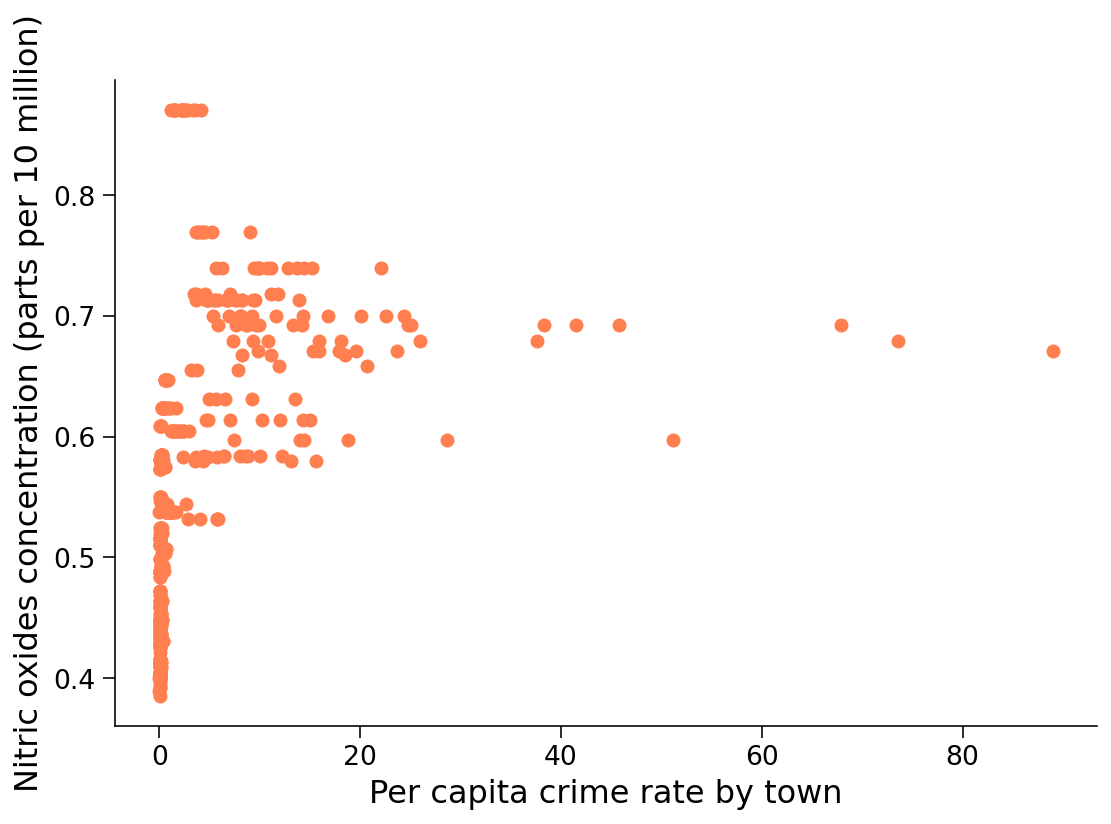

In [ ]:
#@title {run: "auto" }
x_var = "crim" #@param ["crim", "nox", "ptratio", "age", "medv"]
y_var = "nox" #@param ["crim", "nox", "ptratio", "age", "medv"]
axis_labels = {
    "crim":"Per capita crime rate by town",
    "nox":"Nitric oxides concentration (parts per 10 million)",
    "ptratio":"Pupil-teacher ratio by town",
    "age":"Proportion of owner-occupied units built prior to 1940",
    "medv":"Median value of owner-occupied homes in $1000's"
}
# Import data
imported_data = data('Boston')
x = imported_data[x_var]
y = imported_data[y_var]

# bin data
x_binned = bin_data(x,10,'eqspace')
y_binned = bin_data(y,10,'eqspace')

plt.scatter(x,y,color='coral')
plt.xlabel(axis_labels[x_var])
plt.ylabel(axis_labels[y_var])

print("Entropy x = ", entropy(x_binned))
print("Entropy y = ", entropy(y_binned))
print("Conditional entropy (x|y)) =  "
 + str(conditional_entropy(x_binned,y_binned)))
print("Mutual information (x;y)) =  "
 + str(mi(x_binned,y_binned)))

## Discussion
- Can you see a relation between the distributions of X, Y, the conditional entropy $H(X|Y)$ and the mutual information?
  - Try to see what happens with `'crim'` as $X$ and `'nox'` as $Y$
  - What happens with the inverse (i.e. `'crim'` as $Y$ and `'nox'` as $X$)? Is mutual information invariant to swapping $X$ and $Y$?
  - What is the MI of a variable with itself?
  - What is the MI of `'age'` as $X$ and `'medv'` as $Y$?
  - What is the MI of `'nox'` as $X$ and `'ptratio'` as $Y$?

---
# A digression on binning
In this section we will:
- Discuss the effects of number of bins on the calculation of MI
- Consider the difference between binning strategies

As we have seen, calculating entropies and mutual information requires us to know (or better, estimate) probabilities. Broadly speaking, there are two main strategies to achieve this:

1. by fitting a probability distribution to our data (either by assuming its distribution or not)
1. by using our data to create a discrete histogram of the probability distribution (frequently referred to as *plug-in* or *direct* estimation)

The methods of the first class are normally far more computationally expensive but, if done correctly, ensure more reliable results. In a plug-in estimation, instead, we calculate the probabilities using a frequentist approach on the data that we have available. This is the approach that we have followed so far and that we'll follow for the rest of the tutorial.

## Discussion
- Can you think of what are the consequences of using a plug-in estimation?
- Can a plug-in estimation be applied directly to continuous data?

## Binning strategies: uniform-width vs uniform-size
- In uniform-width binning (the approach we followed so far) we divide the range between min and max observed values of the RV of interest in $N$ equally-wide bins.
- In uniform-size (with size here we refer to the population size) bins we split the range bewteen min and max observed values in $N$ bins, all containing the same number of samples.

These are **not** the only strategies used but are the most frequently used. In the sectiob below you will implement binning through equal sizing.

In the section below we will implement the following function:

- `defbin_data(data,nbins,mode):` to bin data using either equally spaced or equally populated bins

In [ ]:
def bin_data(data,nbins,mode):
  # returns binned version of data
  # data is a column vector to be binned: rows are the trials
  # nbins is the number of bins that is going to be used
  # mode is the binning mode, either 'eqspace' for equally spaced bins or 'eqsize' for equally populated bins
  # first implement 'eqspace' mode
  if mode == 'eqspace':
    edges = np.linspace(np.min(data)-0.1,np.max(data)+0.1,nbins+1)
    data_binned = np.digitize(data,edges,right=True)
  # then implement equally sized mode
  elif mode == 'eqsize':
    data_binned = np.zeros_like(data)
    sorted_idxs = np.argsort(data)
    split_idxs = np.array_split(sorted_idxs, nbins)
    bin = 1
    for s_i in split_idxs:
      for i in s_i:
        data_binned[i] = bin
      bin += 1
  else:
    raise ValueError("Wrong binning mode given as input")
  # return data_binned
  return data_binned

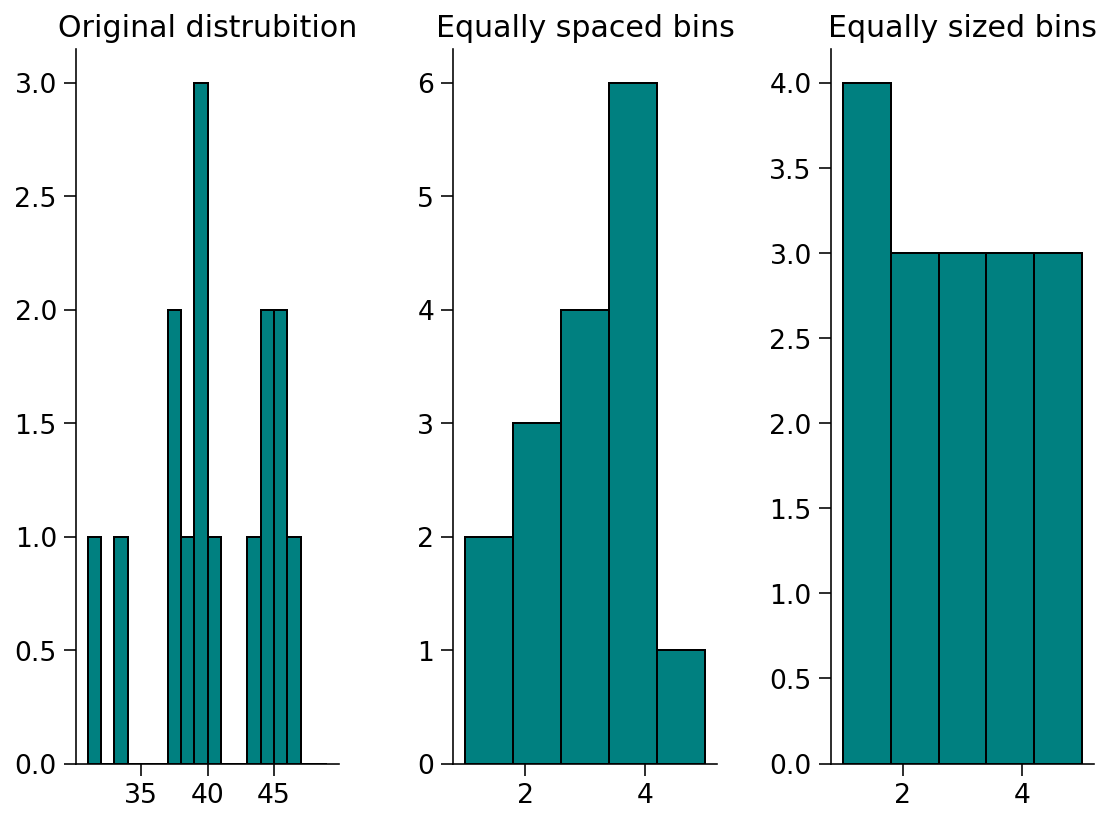

In [ ]:
#@title Histogram resulting from different binning strategies  {run: "auto" }
trials = 16 #@param {type:"slider", min:1, max:1000, step:1}
rate = 4 #@param {type:"slider", min:1, max:10, step:1}
n_bins = 5 #@param {type:"slider", min:2, max:50, step:1}

tm = np.linspace(0,10,2000)

sp_cnt = np.zeros((trials,))
for i,_ in enumerate(sp_cnt):
  sp_cnt[i] = np.sum(poisson_spike(tm,rate))

binned_sp_cnt_esp = bin_data(sp_cnt,n_bins,'eqspace')
binned_sp_cnt_esi = bin_data(sp_cnt,n_bins,'eqsize')

f, axs = plt.subplots(1,3)
_ = axs[0].hist(sp_cnt,bins=np.arange(np.min(sp_cnt),np.max(sp_cnt)),
                color='teal',edgecolor='black')
_ = axs[0].set_title('Original distrubition',
                      fontsize = 15)
_ = axs[1].hist(binned_sp_cnt_esp, bins=n_bins,
                color='teal',edgecolor='black')
_ = axs[1].set_title('Equally spaced bins',
                      fontsize = 15)
_ = axs[2].hist(binned_sp_cnt_esi, bins=n_bins,
                color='teal',edgecolor='black')
_ = axs[2].set_title('Equally sized bins',
                      fontsize = 15)

## Discussion
- What you can immediately see from the different histograms?
- What do you think it's the favourable property of equal width binning?
- Why instead you may prefer equally sized bins?

## Rules of thumb for estimation of the number of bins
The estimation of the number of bins belongs to the category of the *\"(ubiquitous) things in science that are fundamental for something  but having no exact rule to follow for their determination\"*. Much is left to the experience of the user.

There are, however some established rules of thumb that can help:
1. **The Freedman-Diaconis rule** (Freedman, D., Diaconis, P. On the histogram as a density estimator:L 2 theory. Z. Wahrscheinlichkeitstheorie verw Gebiete 57, 453–476 (1981). https://doi.org/10.1007/BF01025868):
$$N = 2\times IQR\times n^{-1/3}$$
where $IQR$ is the inter-quartile range and $n$ is the number of samples.
1. **Scott's rule (normality assumption)** (Scott, D.W., On optimal and data-based histograms, Biometrika, Volume 66, Issue 3, December 1979, Pages 605–610, https://doi.org/10.1093/biomet/66.3.605):
$$N = 3.5\times \sigma\times n^{-1/3}$$
where $\sigma$ is the standard deviation range and $n$ is the number of samples.
1.**Sturges rule (used only for very large number of samples [practically never the case in neuroscience])**(Sturges, Herbert A. "The choice of a class interval." Journal of the american statistical association 21.153 (1926): 65-66):
$$N = 1 + log_2n$$

Another issue with using a plug-in estimate is due to bias. We'll cover this in the next section.

---
# Bias and bias correction strategies
Estimating the probability distribution from a limited size data sample results inevitably in errors. Mutual information is a positive quantity and errors in the probability estimation will **always (on average)** introduce a positive bias.

We have seen that (always on average) limited sampling introduces a negative bias on entropy. Given that the conditional entropy $H(X|Y)$ is estimated on a smaller sample than the marginal entropy $H(X)$ (as it is estimated on a subset of the whole available data) it is going to be affected by a higher negative bias than $H(X)$. As such the MI will be affected by a positive bias.

In this section we will:
- Demonstrate the effect of bias on the calculation of MI
- Implement quadratic extrapolation for bias correction

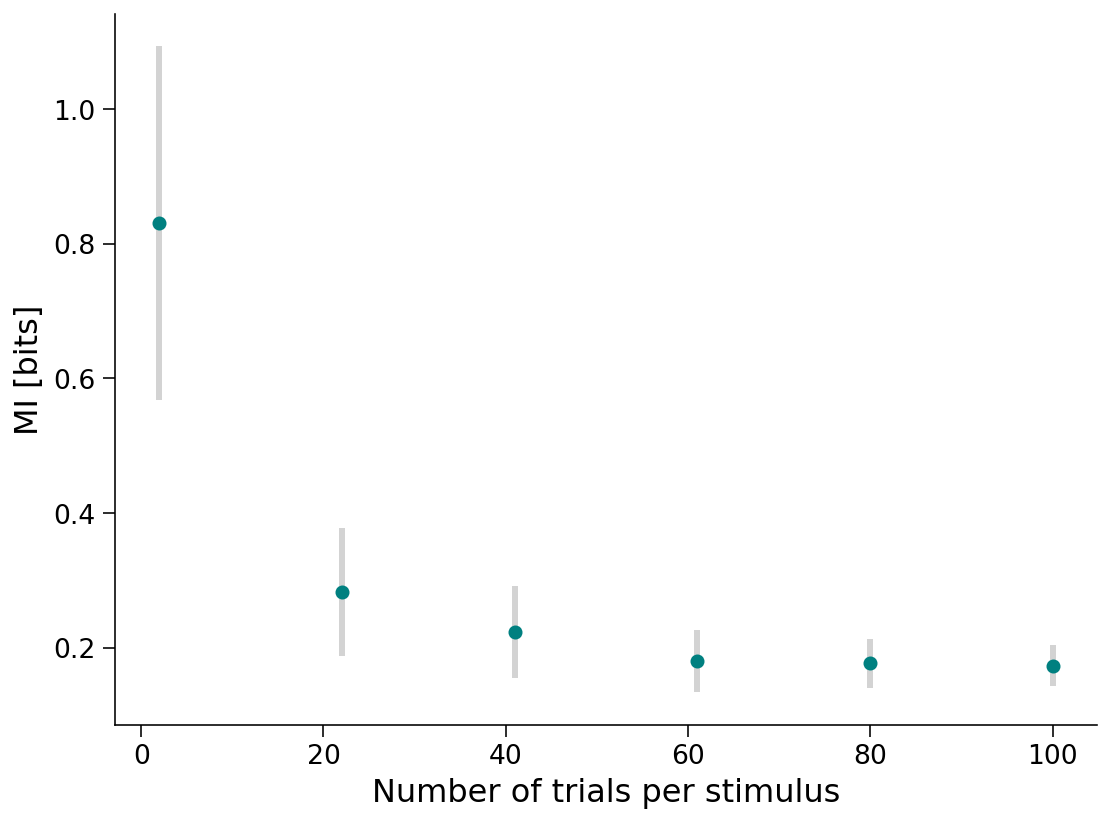

In [ ]:
#@title {run: "auto" }
rate_1 = 3 #@param {type:"slider", min:1, max:10, step:0.5}
rate_2 = 2 #@param {type:"slider", min:1, max:10, step:0.5}
n_bins = 30 #@param {type:"slider", min:2, max:50, step:1}

n_rep_stats = 20
n_trials_to_sample = 6

rate = [rate_1, rate_2]
trials = np.round(np.linspace(2,100,n_trials_to_sample))
tm = np.linspace(0,2,400)
MI = np.zeros((n_trials_to_sample,n_rep_stats))

for t,trials_n in enumerate(trials):
  for r in range(n_rep_stats):
    trials_n = int(trials_n)
    sp_cnt = np.zeros((2*trials_n,))
    # build stimuli array
    stimuli = np.block([1+np.zeros((trials_n,)), 2+np.zeros((trials_n,))])
    # build response array
    for s in [0,1]:
      for i in range(0,trials_n):
        sp_cnt[s*trials_n+i] = np.sum(poisson_spike(tm,rate[s]))
    # bin responses
    binned_sp_cnt = bin_data(sp_cnt,n_bins,'eqspace')
    # calculate MI
    MI[t,r] = mi(stimuli,binned_sp_cnt)

# extract mean values and std for error bars
MI_mn = np.mean(MI,axis=1)
MI_std = np.std(MI,axis=1)
_ = plt.errorbar(trials, MI_mn, yerr=MI_std, fmt='o', color='teal',
             ecolor='lightgray', elinewidth=3, capsize=0);
_ = plt.xlabel("Number of trials per stimulus")
_ = plt.ylabel("MI [bits]")

## Discussion
- What is the effect of bias?
- How does it change as one changes the number of trials/rates difference/number of bins? Why?

## Bias correction through quadratic extrapolation
We have observed that, given a finite number of samples $N$, the MI will be always positively biased. One way to correct for finite sample size bias is to use quadratic extrapolation.

The idea is to calculate $MI_N$, $MI_{N/2}$, $MI_{N/4}$ (the values of MI calculated using respectively $N$, $N/2$, $N/4$ samples. One can then simply infer $MI_{\infty}$ (value of MI with infinite samples) by quadratic extrapolation of $MI_N$, $MI_{N/2}$, $MI_{N/4}$.

In the section below we will implement the following function:

- `def bias_corr_mi(x,y):` to perform bias corrected predictions of MI using quadratic extrapolation

In [ ]:
def bias_corr_mi(x,y):
  # returns bias corrected mutual information between (X;Y) based on observations x,y
  # x is a column vector: rows are the trials
  # y is a column vector: rows are the trials
  # perform n_stats_runs different calculations for a reliable estimation of the the MI using a subset of the original samples
  n_stats_runs = 20
  n_trials = x.size
  # store in MI_n the values of MI obtained with 100%, 50% and 25% of the trials
  MI_n = np.zeros((3,))
  subset_size = np.asarray([n_trials, round(n_trials/2), round(n_trials/4)])
  # calculate MI for N, N/2 and N/4 and store it in MI_n
  for i in range(2):
    MI_tmp = np.empty((n_stats_runs,))
    MI_tmp[:] = np.nan
    for r in range(n_stats_runs):
      subset_indices = np.random.choice(n_trials, subset_size[i])
      MI_tmp[r] = mi(x[subset_indices],y[subset_indices])
      if i==0:
        break
    MI_n[i] = np.nanmean(MI_tmp)
  # perform quadratic extrapolation
  quad = np.polyfit(1/subset_size, MI_n, deg=2)
  bc_MI  = np.polyval(quad, 0)
  # return output bc_MI
  return bc_MI

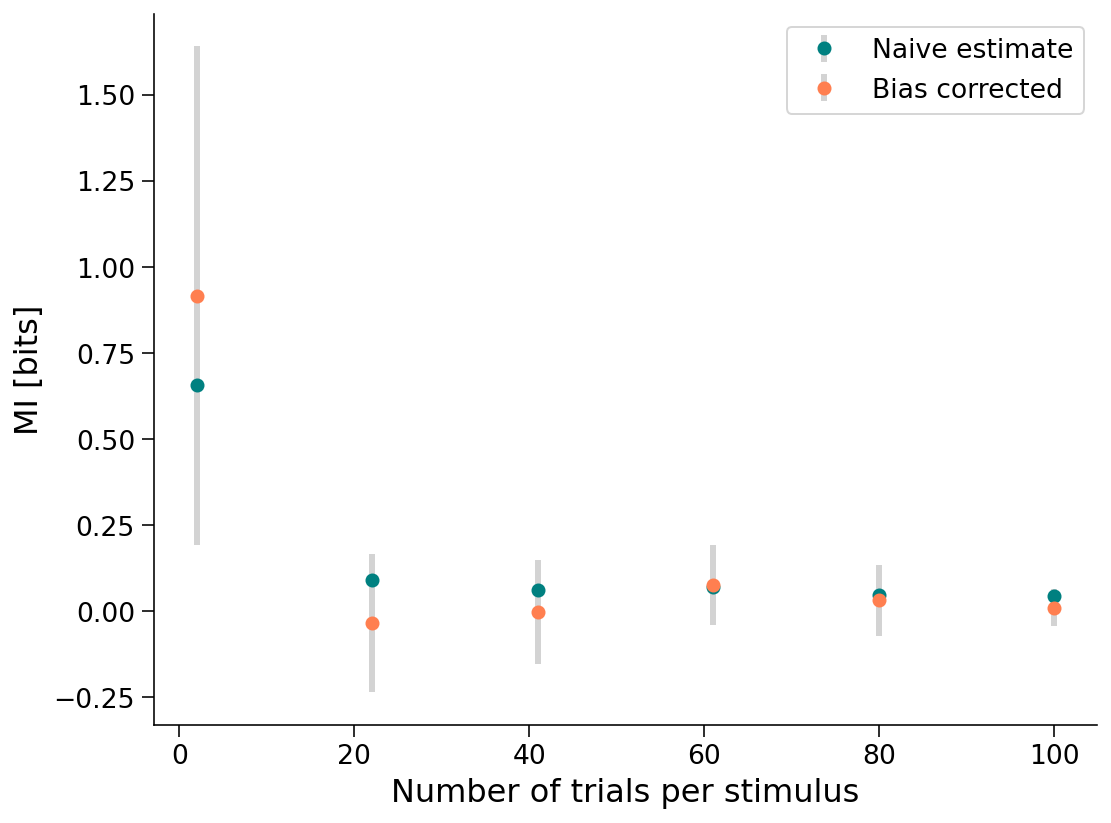

In [ ]:
#@title {run: "auto" }
rate_1 = 2.5 #@param {type:"slider", min:1, max:10, step:0.5}
rate_2 = 2 #@param {type:"slider", min:1, max:10, step:0.5}
n_bins = 4 #@param {type:"slider", min:2, max:50, step:1}

n_rep_stats = 20
n_trials_to_sample = 6

rate = [rate_1, rate_2]
trials = np.round(np.linspace(2,100,n_trials_to_sample))
tm = np.linspace(0,2,400)
MI = np.zeros((n_trials_to_sample,n_rep_stats))
MI_bc = np.zeros((n_trials_to_sample,n_rep_stats))

for t,trials_n in enumerate(trials):
  for r in range(n_rep_stats):
    trials_n = int(trials_n)
    sp_cnt = np.zeros((2*trials_n,))
    # build stimuli array
    stimuli = np.block([1+np.zeros((trials_n,)), 2+np.zeros((trials_n,))])
    # build response array
    for s in [0,1]:
      for i in range(0,trials_n):
        sp_cnt[s*trials_n+i] = np.sum(poisson_spike(tm,rate[s]))
    # bin responses
    binned_sp_cnt = bin_data(sp_cnt,n_bins,'eqspace')
    # calculate MI
    MI[t,r] = mi(stimuli,binned_sp_cnt)
    MI_bc[t,r] = bias_corr_mi(stimuli,binned_sp_cnt)

# extract mean values and std for error bars
MI_mn = np.mean(MI,axis=1)
MI_std = np.std(MI,axis=1)
MI_bc_mn = np.mean(MI_bc,axis=1)
MI_bc_std = np.std(MI_bc,axis=1)
_ = plt.errorbar(trials, MI_mn, yerr=MI_std, fmt='o', color='teal',
             ecolor='lightgray', elinewidth=3, capsize=0,
             label='Naive estimate');
_ = plt.errorbar(trials, MI_bc_mn, yerr=MI_bc_std, fmt='o', color='coral',
             ecolor='lightgray', elinewidth=3, capsize=0,
             label='Bias corrected');            
_ = plt.xlabel("Number of trials per stimulus")
_ = plt.ylabel("MI [bits]")
_ = plt.legend()

---
# Effect of noise correlations in population coding
In this section we will:
- Define the response of 2 neurons to 2 different stimuli and see how noise correlations affect their response:
  - Can we build an hypothesis about the effect on noise correlations on information in neuronal populations?
- Discuss the problems arising from looking at multi-dimensional responses
- Confirm/discard our hypothesis on the effect of noise correlations on information in neuronal populations through numerical calculations


In [ ]:
#@title Noise correlation and MI {run: "auto" }
case = "Case B" #@param ["Case A", "Case B"]
if case == "Case A":
  n1_rate_1 = 10
  n1_rate_2 = 5
  n2_rate_1 = 11
  n2_rate_2 = 5
  sign = [1, 1]
else:
  n1_rate_1 = 10
  n1_rate_2 = 7
  n2_rate_1 = 3
  n2_rate_2 = 5
  sign = [-1, 1]

alpha = 1 #@param {type:"slider", min:0, max:1, step:0.1}

n_trials = 200
sigma = 0.5
n_bins = 2
tm = np.linspace(0,5,1000)
rates = np.array([[n1_rate_1, n2_rate_1],
         [n1_rate_2, n2_rate_2]])
sp_cnt_1 = np.zeros((2*n_trials,))
sp_cnt_2 = np.zeros((2*n_trials,))
sp_cnt = np.zeros((2*n_trials,2))
therates = np.zeros((2*n_trials,2))
binned_sp_cnt = np.zeros_like(sp_cnt)
# build stimuli array
stimuli = np.zeros((2*n_trials,))
# build response array
for s in range(2):
  for i in range(0,n_trials):
    noise_s = np.random.normal(2,1)
    for n in range(2):
      stimuli[s*n_trials+i] = s
      therates[s*n_trials+i,n] = rates[s,n] - sigma*(rates[0,n] - rates[1,n])*\
      (alpha*noise_s+np.sqrt(1-alpha**2)*np.random.normal(0,1))
      sp_cnt[s*n_trials+i,n] = np.sum(poisson_spike(tm,
                                                      rates[s,n] + 
                                                      sign[n]*sigma*(rates[0,n] - rates[1,n])*\
                                                      (alpha*noise_s+np.sqrt(1.0-alpha**2.0)*np.random.normal(0,1))))

# bin responses (independently for each neuron)
for n in [0,1]:
  binned_sp_cnt[:,n] = bin_data(sp_cnt[:,n],n_bins,'eqspace')

# transform response to 1D
one_d_resps = np.zeros((binned_sp_cnt.shape[0],))
unique_resps, p_x = np.unique(binned_sp_cnt, axis=0, return_counts=True)
for i in range(binned_sp_cnt.shape[0]):
  unique_resp_id = np.where(np.all(unique_resps == binned_sp_cnt[i,:],axis=1))[0]
  one_d_resps[i] = unique_resp_id
# plot responses
scattercols = ['teal','coral']
legends = ['Stim 1', 'Stim 2']
for s in [0,1]:
  _ = plt.plot(sp_cnt[s*n_trials:s*n_trials+n_trials-1,0] , sp_cnt[s*n_trials:s*n_trials+n_trials-1,1] , 'o',
               markersize=3, color=scattercols[s], label=legends[s])
  _ = plt.xlabel("Spike count neuron 1 [-]")
_ = plt.ylabel("Spike count neuron 2 [-]")
_ = plt.legend()

# calculate MI
MI = mi(stimuli,one_d_resps)
print("Mutual Information = " + str(MI))
print("Correlation coefficient = " + str(np.corrcoef(sp_cnt,rowvar=False)[0,1]))

## Discussion
- Is *Case A* a case in which correlation limits or enhances information? Why is this the case?
- What about *Case B*?